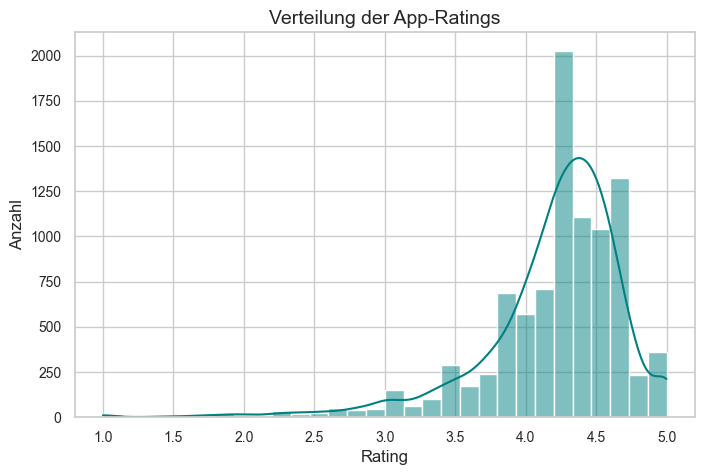

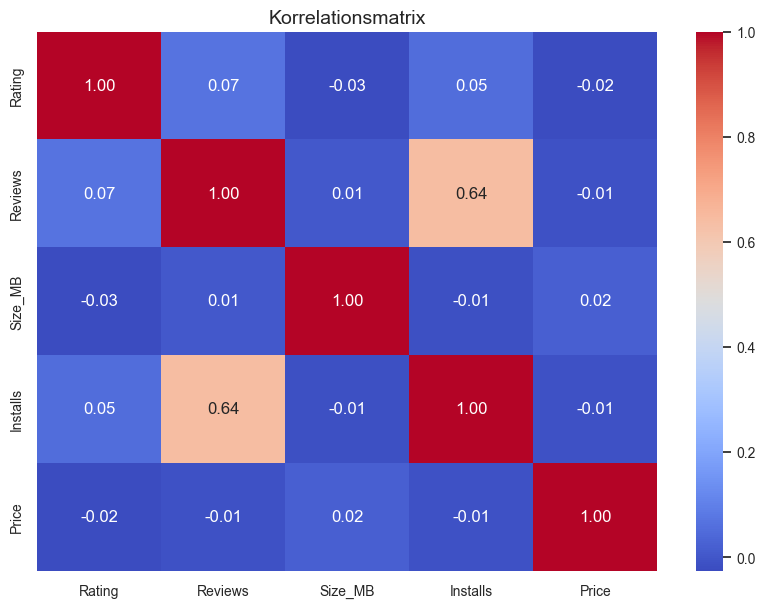

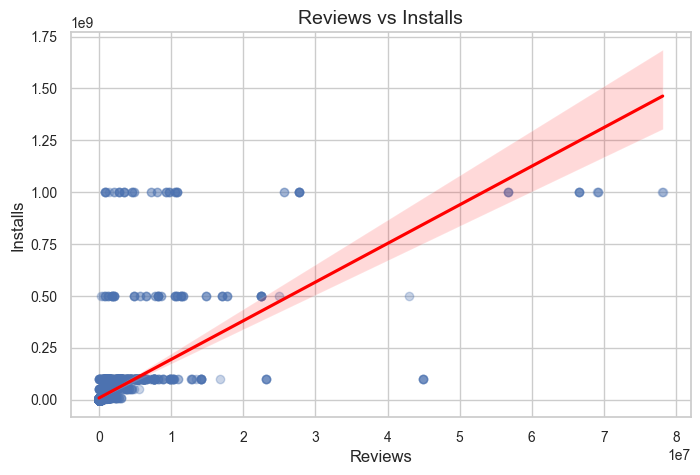

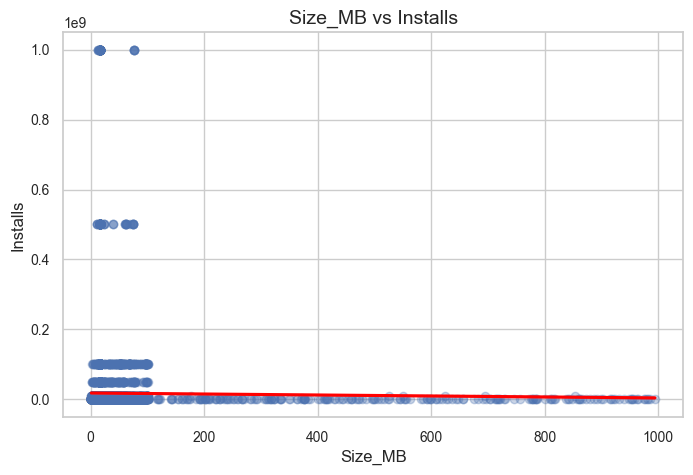

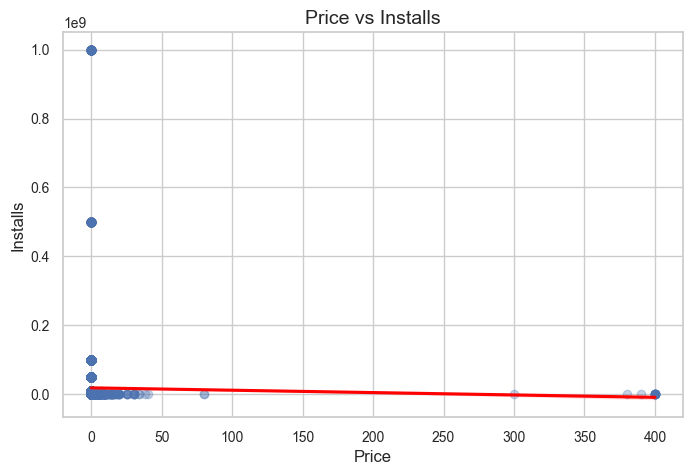

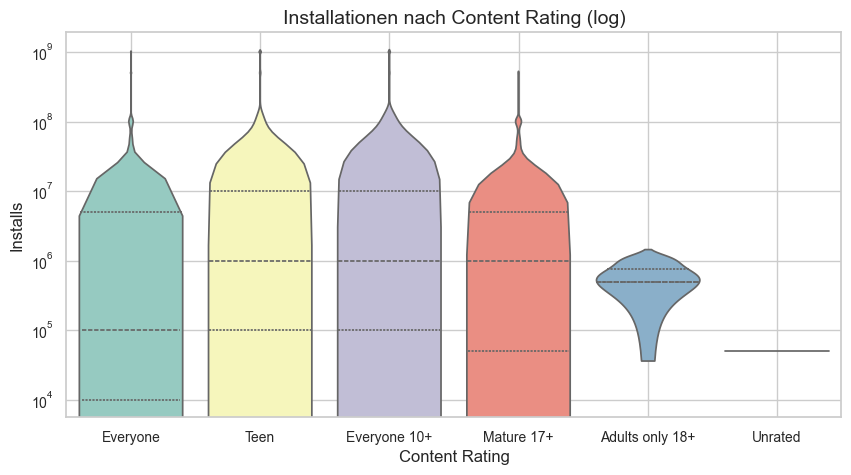

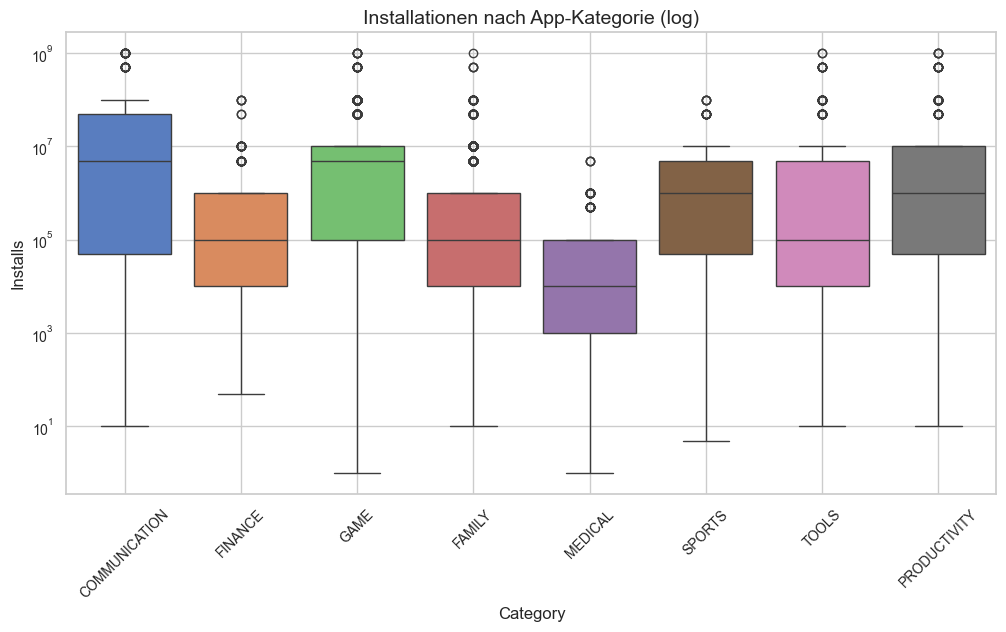

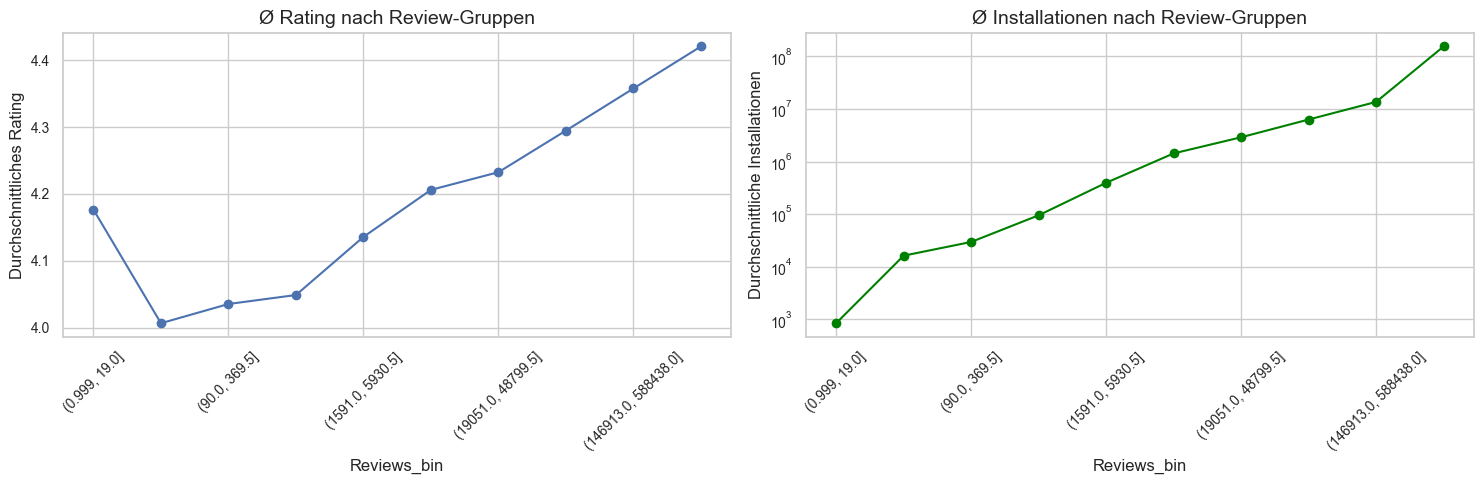

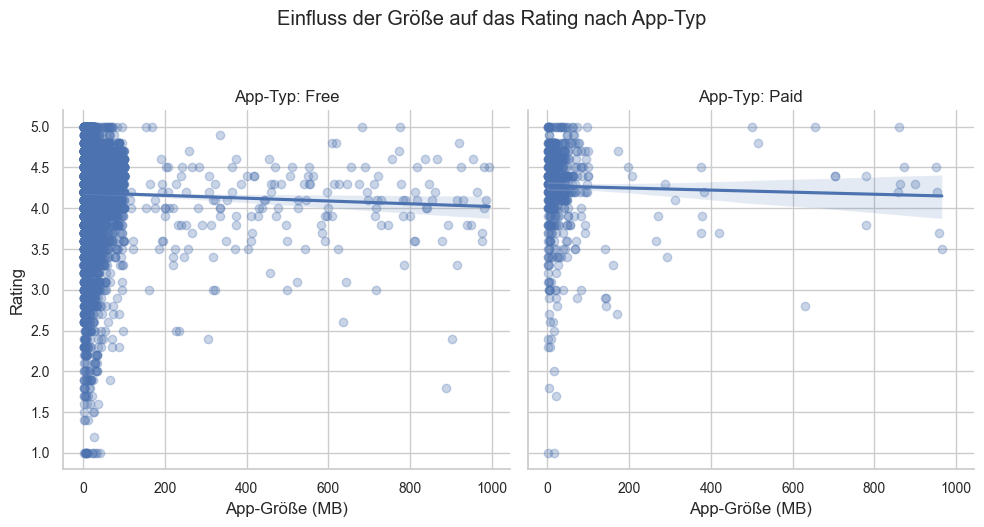

In [4]:
# ðŸ“Š Erweiterte Analyse Google Play Store Daten

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import warnings
warnings.filterwarnings("ignore")

# Stil fÃ¼r bessere Lesbarkeit
sns.set(style="whitegrid")
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10

# ----------------------------------------
# ðŸ“¥ Daten einlesen
# ----------------------------------------
df = pd.read_csv("input/googleplaystore.csv")
df_clean = df.copy()

# ----------------------------------------
# ðŸ”§ Datenbereinigung
# ----------------------------------------

# Rating & Reviews als numerisch
df_clean["Rating"] = pd.to_numeric(df_clean["Rating"], errors="coerce")
df_clean["Reviews"] = pd.to_numeric(df_clean["Reviews"], errors="coerce")

# GrÃ¶ÃŸe umrechnen
df_clean["Size_MB"] = df_clean["Size"].replace("Varies with device", np.nan)
df_clean["Size_MB"] = df_clean["Size_MB"].str.replace("M", "").str.replace("k", "")
df_clean["Size_MB"] = pd.to_numeric(df_clean["Size_MB"], errors="coerce")

# Installs bereinigen
df_clean["Installs"] = df_clean["Installs"].str.replace(r"[+,]", "", regex=True)
df_clean["Installs"] = pd.to_numeric(df_clean["Installs"], errors="coerce")

# Preis bereinigen
df_clean["Price"] = df_clean["Price"].str.replace("$", "", regex=False)
df_clean["Price"] = pd.to_numeric(df_clean["Price"], errors="coerce")

# Entferne fehlende Rating- und Installationswerte
df_clean = df_clean.dropna(subset=["Rating", "Installs"])

# Fehlende numerische Werte durch Median ersetzen
for col in ["Reviews", "Size_MB", "Price"]:
    df_clean[col] = df_clean[col].fillna(df_clean[col].median())

# ----------------------------------------
# ðŸ“ˆ Verteilung von Rating & Installs
# ----------------------------------------

# Verteilung Rating
plt.figure(figsize=(8, 5))
sns.histplot(df_clean["Rating"], bins=30, kde=True, color="teal")
plt.title("Verteilung der App-Ratings")
plt.xlabel("Rating")
plt.ylabel("Anzahl")
plt.grid(True)
plt.show()

# Verteilung Installs (log-skaliert)
plt.figure(figsize=(8, 5))
sns.histplot(df_clean["Installs"], bins=30, kde=True, log_scale=True, color="orange")
plt.title("Verteilung der Installationen (log-skaliert)")
plt.xlabel("Installationen (log)")
plt.ylabel("Anzahl")
plt.grid(True)
plt.show()

# ----------------------------------------
# ðŸ”— Korrelation Heatmap
# ----------------------------------------

numeric_cols = ["Rating", "Reviews", "Size_MB", "Installs", "Price"]
plt.figure(figsize=(10, 7))
corr = df_clean[numeric_cols].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Korrelationsmatrix")
plt.show()

# ----------------------------------------
# ðŸ“Š Scatterplots mit Regressionslinien
# ----------------------------------------

for target in ["Rating", "Installs"]:
    for feature in ["Reviews", "Size_MB", "Price"]:
        plt.figure(figsize=(8, 5))
        sns.regplot(data=df_clean, x=feature, y=target, scatter_kws={"alpha": 0.3}, line_kws={"color": "red"})
        plt.title(f"{feature} vs {target}")
        plt.grid(True)
        plt.show()

# ----------------------------------------
# ðŸŽ» Violinplots â€“ Content Rating vs Rating / Installs
# ----------------------------------------

plt.figure(figsize=(10, 5))
sns.violinplot(data=df_clean, x="Content Rating", y="Rating", inner="quartile", palette="Set2")
plt.title("Rating nach Content Rating")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
sns.violinplot(data=df_clean, x="Content Rating", y="Installs", inner="quartile", palette="Set3")
plt.yscale("log")
plt.title("Installationen nach Content Rating (log)")
plt.grid(True)
plt.show()

# ----------------------------------------
# ðŸ“¦ Boxplots nach Kategorie
# ----------------------------------------

top_categories = df_clean["Category"].value_counts().nlargest(8).index

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_clean[df_clean["Category"].isin(top_categories)],
            x="Category", y="Rating", palette="pastel")
plt.title("Rating nach App-Kategorie")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_clean[df_clean["Category"].isin(top_categories)],
            x="Category", y="Installs", palette="muted")
plt.yscale("log")
plt.title("Installationen nach App-Kategorie (log)")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# ----------------------------------------
# ðŸ“ˆ Linienplots â€“ Durchschnitts-Rating/Installs nach Reviews-Gruppe
# ----------------------------------------

df_clean["Reviews_bin"] = pd.qcut(df_clean["Reviews"], 10, duplicates='drop')
grouped_rating = df_clean.groupby("Reviews_bin")["Rating"].mean()
grouped_installs = df_clean.groupby("Reviews_bin")["Installs"].mean()

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

grouped_rating.plot(ax=axs[0], marker="o", title="Ã˜ Rating nach Review-Gruppen")
axs[0].set_ylabel("Durchschnittliches Rating")
axs[0].tick_params(axis='x', rotation=45)

grouped_installs.plot(ax=axs[1], marker="o", color="green", title="Ã˜ Installationen nach Review-Gruppen")
axs[1].set_ylabel("Durchschnittliche Installationen")
axs[1].set_yscale("log")
axs[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# ----------------------------------------
# ðŸ§® Facetten-Diagramm: GrÃ¶ÃŸe vs Rating nach Type
# ----------------------------------------

g = sns.lmplot(data=df_clean, x="Size_MB", y="Rating", col="Type", height=5, aspect=1, scatter_kws={'alpha':0.3})
g.set_titles("App-Typ: {col_name}")
g.set_axis_labels("App-GrÃ¶ÃŸe (MB)", "Rating")
plt.suptitle("Einfluss der GrÃ¶ÃŸe auf das Rating nach App-Typ", y=1.05)
plt.tight_layout()
plt.show()


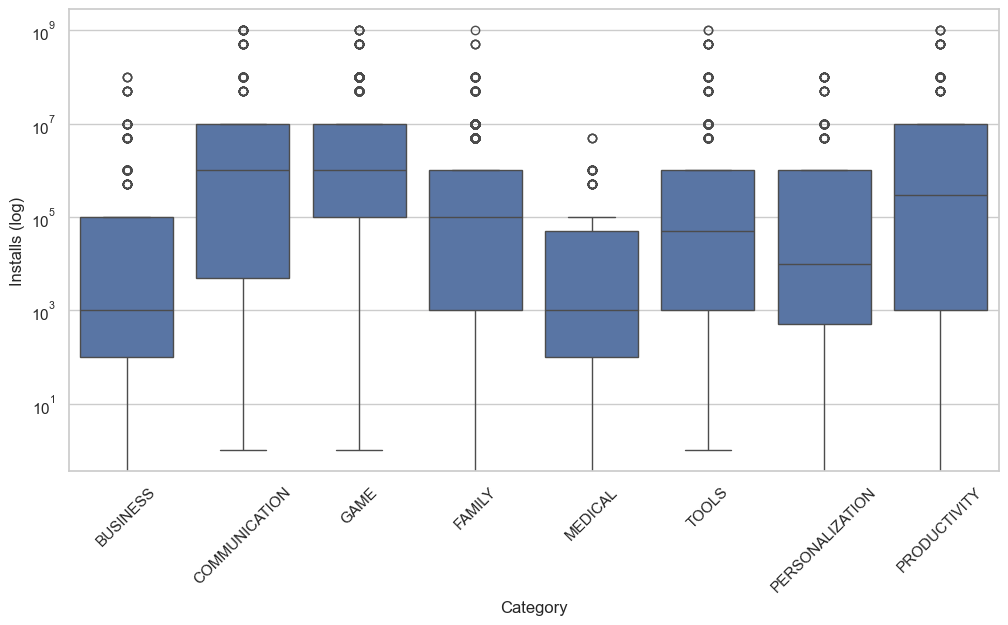

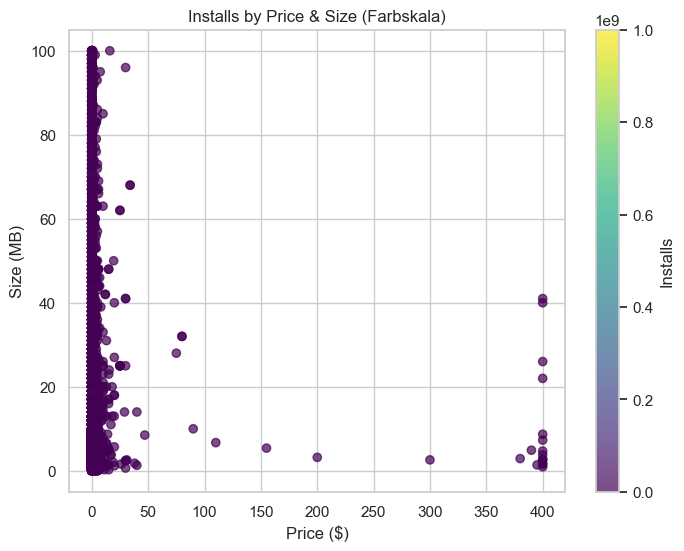

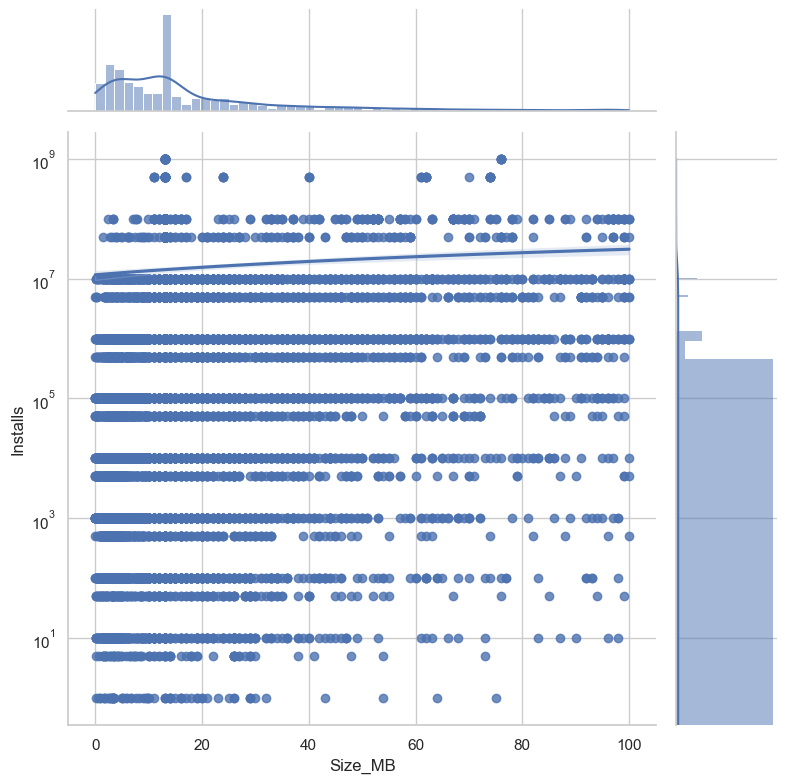

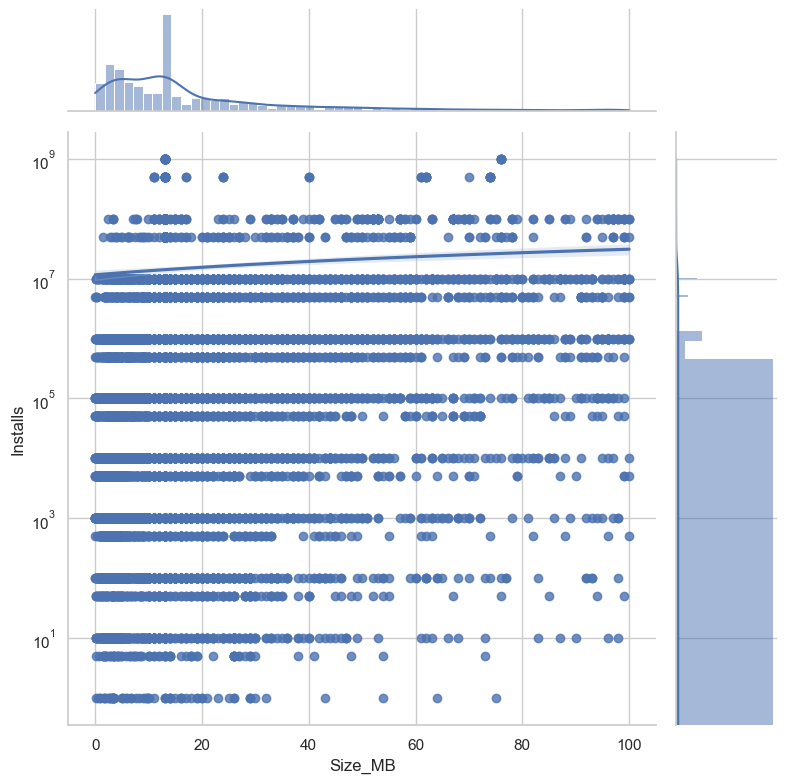

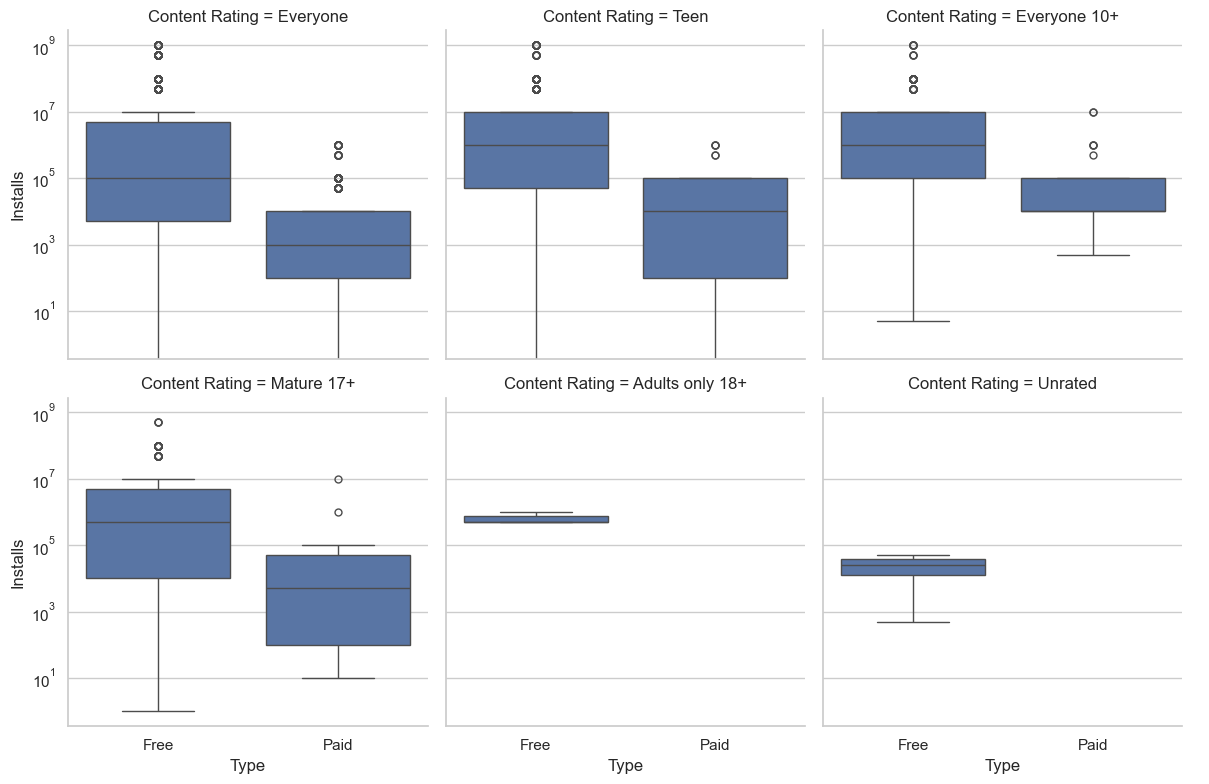

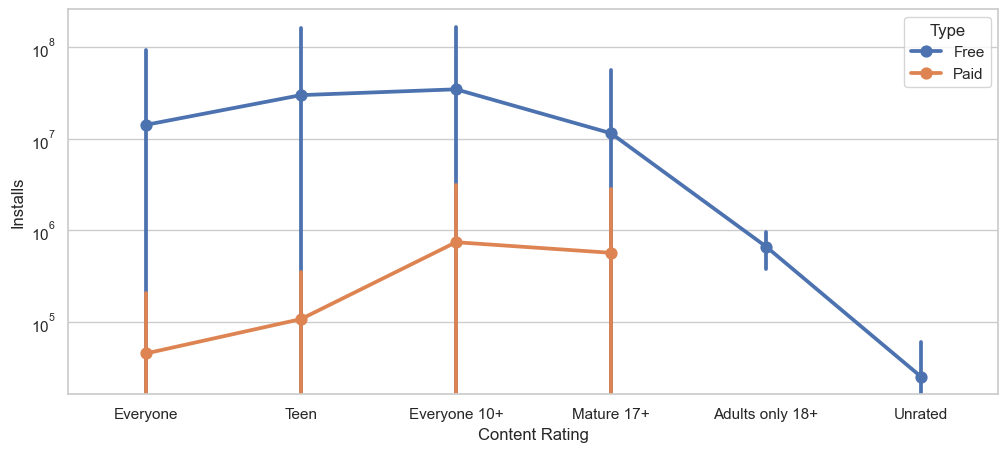

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# ðŸ“¥ Daten laden
df = pd.read_csv("input/googleplaystore.csv")

# ðŸ”§ Datenbereinigung
df = df.dropna(subset=["Installs", "Price", "Size", "Category", "Type", "Content Rating"])

# ðŸ”„ 'Installs' bereinigen
df["Installs"] = df["Installs"].str.replace("[+,]", "", regex=True).astype(float)

# ðŸ”„ Preis bereinigen
df["Price"] = df["Price"].str.replace("$", "", regex=False).astype(float)

# ðŸ”„ GrÃ¶ÃŸe umwandeln
df["Size_MB"] = df["Size"].replace("Varies with device", pd.NA)
df["Size_MB"] = df["Size_MB"].str.replace("M", "", regex=False).str.replace("k", "", regex=False)
df["Size_MB"] = pd.to_numeric(df["Size_MB"], errors="coerce")
df.loc[df["Size"].str.contains("k", na=False), "Size_MB"] /= 1024
df["Size_MB"].fillna(df["Size_MB"].median(), inplace=True)

# ðŸ“Š Plot-Stil
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.violinplot(x="Type", y="Installs", data=df)
plt.yscale("log")
plt.ylabel("Installs (log)")
plt.show()
top_categories = df["Category"].value_counts().nlargest(8).index
df_top = df[df["Category"].isin(top_categories)]

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_top, x="Category", y="Installs")
plt.yscale("log")
plt.xticks(rotation=45)
plt.ylabel("Installs (log)")
plt.show()
plt.figure(figsize=(8, 6))
sc = plt.scatter(df["Price"], df["Size_MB"], c=df["Installs"], cmap="viridis", alpha=0.7)
plt.colorbar(sc, label="Installs")
plt.xlabel("Price ($)")
plt.ylabel("Size (MB)")
plt.title("Installs by Price & Size (Farbskala)")
plt.show()
sns.jointplot(data=df, x="Size_MB", y="Installs", kind="reg", height=8)
plt.yscale("log")
plt.show()
sns.jointplot(data=df, x="Size_MB", y="Installs", kind="reg", height=8)
plt.yscale("log")
plt.show()
pivot_table = df.pivot_table(index="Category", columns="Content Rating", values="Installs", aggfunc="mean")
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=False, cmap="Blues", fmt=".0f")
plt.ylabel("Category")
plt.xlabel("Content Rating")
plt.title("Avg. Installs per Category & Rating")
plt.show()
g = sns.catplot(data=df, x="Type", y="Installs", col="Content Rating",
                kind="box", col_wrap=3, height=4)
for ax in g.axes.flatten():
    ax.set_yscale("log")
plt.show()
plt.figure(figsize=(12, 5))
sns.pointplot(data=df, x="Content Rating", y="Installs", hue="Type", ci="sd")
plt.yscale("log")
plt.show()


